In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import wandb
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import time

In [4]:
class TransliterationDataset(Dataset):
    def __init__(self, file_path, source_vocab=None, target_vocab=None, build_vocab=False):
        self.data = []
        
        # Special tokens
        self.SOW = '>'  # Start of word
        self.EOW = '<'  # End of word
        self.PAD = '.'  # Padding
        self.UNK = '?'  # Unknown
        
        # Special token indices
        self.SOW_idx = 0
        self.EOW_idx = 1
        self.PAD_idx = 2
        self.UNK_idx = 3
        
        # Read TSV file
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    target, source = parts[0], parts[1]
                    self.data.append((source, target))
        
        # Build or use provided vocabularies
        if build_vocab:
            source_chars = set()
            target_chars = set()
            
            for source, target in self.data:
                source_chars.update(source)
                target_chars.update(target)
            
            # Create vocabularies
            self.source_char2int = {char: i + 4 for i, char in enumerate(sorted(source_chars))}
            self.target_char2int = {char: i + 4 for i, char in enumerate(sorted(target_chars))}
            
            # Add special tokens
            for token, idx in [(self.SOW, self.SOW_idx), (self.EOW, self.EOW_idx), 
                              (self.PAD, self.PAD_idx), (self.UNK, self.UNK_idx)]:
                self.source_char2int[token] = idx
                self.target_char2int[token] = idx
            
            # Create reverse vocabularies
            self.source_int2char = {i: char for char, i in self.source_char2int.items()}
            self.target_int2char = {i: char for char, i in self.target_char2int.items()}
        else:
            self.source_char2int = source_vocab[0]
            self.target_char2int = target_vocab[0]
            self.source_int2char = source_vocab[1]
            self.target_int2char = target_vocab[1]
        
        # Calculate max length
        self.max_length = max([len(source) for source, _ in self.data] + 
                             [len(target) for _, target in self.data]) + 2  # +2 for SOW and EOW
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        source, target = self.data[idx]
        
        # Convert source to indices
        source_indices = [self.source_char2int.get(char, self.UNK_idx) for char in source]
        source_indices.append(self.EOW_idx)  # Add EOW
        source_indices.extend([self.PAD_idx] * (self.max_length - len(source_indices)))
        
        # Convert target to indices
        target_indices = [self.target_char2int.get(char, self.UNK_idx) for char in target]
        
        # Create decoder input (add SOW at beginning)
        decoder_input = [self.SOW_idx] + target_indices
        decoder_input.extend([self.PAD_idx] * (self.max_length - len(decoder_input)))
        
        # Create decoder target (add EOW at end)
        decoder_target = target_indices + [self.EOW_idx]
        decoder_target.extend([self.PAD_idx] * (self.max_length - len(decoder_target)))
        
        return {
            'source': torch.tensor(source_indices, dtype=torch.long),
            'decoder_input': torch.tensor(decoder_input, dtype=torch.long),
            'decoder_target': torch.tensor(decoder_target, dtype=torch.long),
            'source_text': source,
            'target_text': target
        }
    
    def get_vocab(self):
        return (self.source_char2int, self.source_int2char), (self.target_char2int, self.target_int2char)

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0.2, cell_type='lstm'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # Default to RNN
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len]
        
        # Embedding
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, seq_len, embedding_size]
        
        # RNN forward pass
        if self.cell_type == 'lstm':
            outputs, (hidden, cell) = self.rnn(embedded)
            return outputs, (hidden, cell)
        else:  # GRU or RNN
            outputs, hidden = self.rnn(embedded)
            return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, dropout=0.2, cell_type='lstm'):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # Default to RNN
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden):
        # x shape: [batch_size, 1]
        
        # Embedding
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, 1, embedding_size]
        
        # RNN forward pass
        if self.cell_type == 'lstm':
            output, (hidden, cell) = self.rnn(embedded, hidden)
            # output shape: [batch_size, 1, hidden_size]
            
            prediction = self.softmax(self.fc_out(output))
            # prediction shape: [batch_size, 1, output_size]
            
            return prediction, (hidden, cell)
        else:  # GRU or RNN
            output, hidden = self.rnn(embedded, hidden)
            # output shape: [batch_size, 1, hidden_size]
            
            prediction = self.softmax(self.fc_out(output))
            # prediction shape: [batch_size, 1, output_size]
            
            return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source shape: [batch_size, source_len]
        # target shape: [batch_size, target_len]
        
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        
        # Encode the source sequence
        _, encoder_hidden = self.encoder(source)
        
        # First input to the decoder is the <SOW> token
        decoder_input = target[:, 0].unsqueeze(1)
        
        # Adjust hidden state if encoder and decoder have different numbers of layers
        decoder_hidden = self.adjust_hidden_state(encoder_hidden)
        
        # Teacher forcing: use real target outputs as next input with probability
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        # Decode one step at a time
        for t in range(1, target_len):
            # Pass decoder input and hidden state to decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            # Store prediction
            outputs[:, t, :] = decoder_output.squeeze(1)
            
            # Get the highest predicted token
            top1 = decoder_output.argmax(2)
            
            # Teacher forcing
            decoder_input = target[:, t].unsqueeze(1) if use_teacher_forcing else top1
        
        return outputs
    
    def adjust_hidden_state(self, encoder_hidden):
        """Adjust encoder hidden state to match decoder layers"""
        # For LSTM, encoder_hidden is a tuple (hidden, cell)
        if isinstance(encoder_hidden, tuple):
            encoder_h, encoder_c = encoder_hidden
            encoder_layers = encoder_h.size(0)
            decoder_layers = self.decoder.num_layers
            
            if encoder_layers == decoder_layers:
                return encoder_hidden
            
            # If encoder has fewer layers than decoder, repeat the last layer
            elif encoder_layers < decoder_layers:
                new_h = encoder_h.clone()
                new_c = encoder_c.clone()
                
                # Pad with copies of the last layer
                for i in range(decoder_layers - encoder_layers):
                    new_h = torch.cat([new_h, encoder_h[-1:]], dim=0)
                    new_c = torch.cat([new_c, encoder_c[-1:]], dim=0)
                
                return (new_h, new_c)
            
            # If encoder has more layers than decoder, take the last n layers
            else:
                return (encoder_h[-decoder_layers:], encoder_c[-decoder_layers:])
        
        # For GRU/RNN, encoder_hidden is just the hidden state
        else:
            encoder_layers = encoder_hidden.size(0)
            decoder_layers = self.decoder.num_layers
            
            if encoder_layers == decoder_layers:
                return encoder_hidden
            
            # If encoder has fewer layers than decoder, repeat the last layer
            elif encoder_layers < decoder_layers:
                new_h = encoder_hidden.clone()
                
                # Pad with copies of the last layer
                for i in range(decoder_layers - encoder_layers):
                    new_h = torch.cat([new_h, encoder_hidden[-1:]], dim=0)
                
                return new_h
            
            # If encoder has more layers than decoder, take the last n layers
            else:
                return encoder_hidden[-decoder_layers:]
    
    def beam_search_decode(self, source, target_vocab, beam_width=3, max_length=50):
        # Encode the source sequence
        _, encoder_hidden = self.encoder(source)
        
        # Adjust hidden state for decoder
        decoder_hidden = self.adjust_hidden_state(encoder_hidden)
        
        # Start with <SOW> token
        start_token = torch.tensor([[target_vocab[0]['>']]]).to(self.device)
        
        # Initialize beams: (sequence, score, hidden_state)
        beams = [(start_token, 0.0, decoder_hidden)]
        completed_beams = []
        
        # Beam search loop
        for _ in range(max_length):
            new_beams = []
            
            for beam_seq, beam_score, beam_hidden in beams:
                # If the last token is <EOW>, add to completed beams
                if beam_seq[0, -1].item() == target_vocab[0]['<']:
                    completed_beams.append((beam_seq, beam_score))
                    continue
                
                # Decode one step
                decoder_output, decoder_hidden = self.decoder(beam_seq[:, -1:], beam_hidden)
                
                # Get top-k predictions
                log_probs, indices = decoder_output[0].topk(beam_width)
                
                # Create new beams
                for i in range(beam_width):
                    token_idx = indices[0, i].item()
                    token_prob = log_probs[0, i].item()
                    
                    # Create new sequence
                    new_seq = torch.cat([beam_seq, torch.tensor([[token_idx]]).to(self.device)], dim=1)
                    
                    # Update score (sum of log probabilities)
                    new_score = beam_score + token_prob
                    
                    # Add to new beams
                    new_beams.append((new_seq, new_score, decoder_hidden))
            
            # Keep only the top beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            
            # If all beams are completed, break
            if not beams:
                break
        
        # If no completed beams, take the best incomplete one
        if not completed_beams and beams:
            completed_beams = [(beams[0][0], beams[0][1])]
        
        # Return the best beam
        if completed_beams:
            best_beam = max(completed_beams, key=lambda x: x[1])
            return best_beam[0][0].cpu().numpy()
        else:
            return []

In [5]:
def train(model, iterator, optimizer, criterion, clip, device, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0
    
    for batch in iterator:
        # Get source and target tensors
        source = batch['source'].to(device)
        target = batch['decoder_input'].to(device)
        target_output = batch['decoder_target'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(source, target, teacher_forcing_ratio)
        
        # Calculate loss (ignore padding)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Remove first token (<SOW>)
        target_output = target_output[:, :-1].reshape(-1)  # Remove last token (padding)
        
        loss = criterion(output, target_output)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    correct_words = 0
    total_words = 0
    
    with torch.no_grad():
        for batch in iterator:
            source = batch['source'].to(device)
            target = batch['decoder_input'].to(device)
            target_output = batch['decoder_target'].to(device)
            source_text = batch['source_text']
            target_text = batch['target_text']
            
            # Forward pass
            output = model(source, target, 0)  # No teacher forcing during evaluation
            
            # Calculate loss
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target_output = target_output[:, :-1].reshape(-1)
            
            loss = criterion(output, target_output)
            
            epoch_loss += loss.item()
            
            # Calculate word accuracy
            batch_size = source.shape[0]
            output = output.reshape(batch_size, -1, output_dim)
            
            for i in range(batch_size):
                # Get predicted word
                pred_indices = output[i].argmax(dim=1)
                pred_word = []
                
                for idx in pred_indices:
                    if idx == 1:  # EOW token
                        break
                    if idx > 3:  # Skip special tokens
                        pred_word.append(iterator.dataset.target_int2char[idx.item()])
                
                pred_word = ''.join(pred_word)
                
                # Check if prediction matches target
                if pred_word == target_text[i]:
                    correct_words += 1
                total_words += 1
    
    return epoch_loss / len(iterator), (correct_words / total_words) * 100

def beam_search_evaluate(model, iterator, device, beam_width=3):
    model.eval()
    correct_words = 0
    total_words = 0
    target_vocab = iterator.dataset.get_vocab()[1]
    
    with torch.no_grad():
        for batch in iterator:
            source = batch['source'].to(device)
            target_text = batch['target_text']
            
            # Process one sample at a time for beam search
            for i in range(source.shape[0]):
                src = source[i:i+1]
                
                # Beam search decoding
                beam_result = model.beam_search_decode(src, target_vocab, beam_width)
                
                # Convert indices to characters
                pred_word = []
                for idx in beam_result:
                    if idx == 1:  # EOW token
                        break
                    if idx > 3:  # Skip special tokens
                        pred_word.append(iterator.dataset.target_int2char[idx])
                
                pred_word = ''.join(pred_word)
                
                # Check if prediction matches target
                if pred_word == target_text[i]:
                    correct_words += 1
                total_words += 1
    
    return (correct_words / total_words) * 100

In [5]:
def train_model(config):
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load data
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    val_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv', 
                                        train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
    
    # Get vocabulary sizes
    source_vocab_size = len(train_dataset.source_char2int)
    target_vocab_size = len(train_dataset.target_char2int)
    
    # Create model
    encoder = Encoder(
        input_size=source_vocab_size,
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['encoder_layers'],
        dropout=config['dropout'] if config['encoder_layers'] > 1 else 0,  # Only use dropout if layers > 1
        cell_type=config['cell_type']
    )
    
    decoder = Decoder(
        output_size=target_vocab_size,
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['decoder_layers'],
        dropout=config['dropout'] if config['decoder_layers'] > 1 else 0,  # Only use dropout if layers > 1
        cell_type=config['cell_type']
    )
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.NAdam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.NLLLoss(ignore_index=train_dataset.PAD_idx)
    
    # Training loop
    train_losses = []
    val_losses = []
    val_accs = []
    
    for epoch in range(config['epochs']):
        start_time = time.time()
        
        # Train
        train_loss = train(model, train_loader, optimizer, criterion, config['clip'], device)
        train_losses.append(train_loss)
        
        # Evaluate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc:.2f}%')
        
        # Log to wandb
        if config['use_wandb']:
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'epoch': epoch
            })
    
    # Evaluate on test set using the final model
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
    
    # Log final metrics
    if config['use_wandb']:
        wandb.log({
            'test_loss': test_loss,
            'test_acc': test_acc
        })
        # Explicitly finish the wandb run to avoid hanging
        wandb.finish()
    
    return model, test_acc

In [6]:
import wandb
from kaggle_secrets import UserSecretsClient

# Get your W&B API key from Kaggle secrets
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")

# Login to W&B
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yashgawande25 (yashgawande25-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def run_sweep():
    sweep_config = {
        'method': 'bayes',  # Bayesian optimization
        'name': '3',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'batch_size': {'values': [32, 64, 128]},
            'embedding_size': {'values': [64, 128, 256]},
            'hidden_size': {'values': [128, 256, 512]},
            'encoder_layers': {'values': [1, 2, 3]},
            'decoder_layers': {'values': [1, 2, 3]},
            'cell_type': {'values': ['rnn', 'gru']}, 
            'dropout': {'values': [0.2, 0.3]},
            'learning_rate': {'values': [1e-2, 5e-3, 1e-3, 5e-4]},
            'clip': {'value': 1.0},
            'epochs': {'value': 10},  
            'beam_width': {'values': [1, 3]}
        }
    }
    
    # Initialize wandb
    wandb.login()
    
    # Create sweep
    sweep_id = wandb.sweep(sweep_config, project="da6401_a3")
    
    # Define training function for sweep
    def sweep_train():
        try:
            with wandb.init() as run:
                config = wandb.config
                config['use_wandb'] = True
                
                run_name = (
                    f"{wandb.config.cell_type}_"
                    f"lr_{wandb.config.learning_rate}_"
                    f"enc_lay_{wandb.config.encoder_layers}_"
                    f"dec_lay_{wandb.config.decoder_layers}"
                )
                wandb.run.name = run_name  # Set the run name
                
                train_model(config)
        except Exception as e:
            print(f"Error in sweep run: {e}")
            # Make sure wandb run is finished even if there's an error
            wandb.finish()
    
    # Run sweep
    wandb.agent(sweep_id, function=sweep_train, count=15)  # Adjust count as needed

# Uncomment to run sweep
run_sweep()

In [7]:
def train_and_evaluate_best_model():
    # Best hyperparameters (determined from your sweep)
    config = {
        'batch_size': 128,
        'embedding_size': 256,
        'hidden_size': 512,
        'encoder_layers': 3,
        'decoder_layers': 3,
        'cell_type': 'lstm',  # Your best model's cell type
        'dropout': 0.2,
        'learning_rate': 5e-4,
        'clip': 1.0,
        'epochs': 10,
        'beam_width': 3,
        'use_wandb': True  # Log to wandb
    }
    
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load data
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    val_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv', 
                                        train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
    
    # Get vocabulary sizes
    source_vocab_size = len(train_dataset.source_char2int)
    target_vocab_size = len(train_dataset.target_char2int)
    
    # Initialize wandb
    if config['use_wandb']:
        wandb.init(project="da6401_a3", name="best_vanilla_model")
        wandb.config.update(config)
    
    # Create model
    encoder = Encoder(
        input_size=source_vocab_size,
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['encoder_layers'],
        dropout=config['dropout'] if config['encoder_layers'] > 1 else 0,
        cell_type=config['cell_type']
    )
    
    decoder = Decoder(
        output_size=target_vocab_size,
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['decoder_layers'],
        dropout=config['dropout'] if config['decoder_layers'] > 1 else 0,
        cell_type=config['cell_type']
    )
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.NAdam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.NLLLoss(ignore_index=train_dataset.PAD_idx)
    
    # Training loop
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(config['epochs']):
        start_time = time.time()
        
        # Train
        train_loss = train(model, train_loader, optimizer, criterion, config['clip'], device)
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {key: value.cpu().clone() for key, value in model.state_dict().items()}
            torch.save(model.state_dict(), 'best_vanilla_model.pt')
        
        # Log to wandb
        if config['use_wandb']:
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'epoch': epoch
            })
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
    
    # Evaluate with beam search
    beam_acc = beam_search_evaluate(model, test_loader, device, config['beam_width'])
    print(f'Beam Search Test Acc (width={config["beam_width"]}): {beam_acc:.2f}%')
    
    # Log final metrics
    if config['use_wandb']:
        wandb.log({
            'test_loss': test_loss,
            'test_acc': test_acc,
            'beam_search_acc': beam_acc
        })
        wandb.finish()
    
    return model, train_dataset, test_acc, beam_acc

def generate_test_predictions(model_path='/kaggle/working/best_vanilla_model.pt', beam_width=3):
    """
    Generate predictions for all test data and save to a file
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load train dataset to get vocabulary
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    source_vocab, target_vocab = train_dataset.get_vocab()
    
    # Load test dataset
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         source_vocab, target_vocab)
    
    # Create model with same architecture as training
    encoder = Encoder(
        input_size=len(source_vocab[0]),
        embedding_size=256,  # Use the same values as in training
        hidden_size=512,
        num_layers=3,
        dropout=0.2,
        cell_type='lstm'
    )
    
    decoder = Decoder(
        output_size=len(target_vocab[0]),
        embedding_size=256,
        hidden_size=512,
        num_layers=3,
        dropout=0.2,
        cell_type='lstm'
    )
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Create directory for predictions
    os.makedirs('predictions_vanilla', exist_ok=True)
    
    # Generate predictions
    predictions = []
    
    with torch.no_grad():
        for i, item in enumerate(test_dataset):
            source = item['source'].unsqueeze(0).to(device)  # Add batch dimension
            source_text = item['source_text']
            target_text = item['target_text']
            
            # Beam search decoding
            beam_result = model.beam_search_decode(source, target_vocab, beam_width)
            
            # Convert indices to characters
            pred_word = []
            for idx in beam_result:
                if idx == test_dataset.EOW_idx:
                    break
                if idx > 3:  # Skip special tokens
                    pred_word.append(target_vocab[1][idx])
            
            pred_word = ''.join(pred_word)
            
            # Store prediction
            predictions.append({
                'source': source_text,
                'target': target_text,
                'prediction': pred_word,
                'correct': pred_word == target_text
            })
    
    # Save predictions to CSV file with UTF-8-BOM encoding for Excel compatibility
    df = pd.DataFrame(predictions)
    df.to_csv('predictions_vanilla/predictions.csv', index=False, encoding='utf-8-sig')
    
    # Also save as text file with UTF-8 encoding
    with open('predictions_vanilla/predictions.txt', 'w', encoding='utf-8') as f:
        for pred in predictions:
            f.write(f"{pred['source']}\t{pred['prediction']}\t{pred['target']}\t{pred['correct']}\n")
    
    # Calculate accuracy
    correct = sum(1 for pred in predictions if pred['correct'])
    accuracy = correct / len(predictions) * 100
    
    print(f"Generated predictions for {len(predictions)} test examples")
    print(f"Beam Search Accuracy (width={beam_width}): {accuracy:.2f}%")
    
    return predictions


def display_sample_predictions(predictions=None, model_path='/kaggle/working/best_vanilla_model.pt', num_samples=20, beam_width=3):
    """
    Display sample predictions in a creative way
    Samples are selected randomly to maintain the actual distribution of correct/incorrect predictions
    """
    if predictions is None:
        # If predictions not provided, generate them
        predictions = generate_test_predictions(model_path, beam_width)
    
    # Calculate actual accuracy
    correct_count = sum(1 for p in predictions if p['correct'])
    total_count = len(predictions)
    accuracy = correct_count / total_count
    
    print(f"Overall accuracy: {accuracy:.2%} ({correct_count}/{total_count})")
    
    # Sample randomly to maintain the actual distribution
    random.seed(42)  # For reproducibility
    samples = random.sample(predictions, min(num_samples, len(predictions)))
    
    # Count correct/incorrect in our sample
    sample_correct = sum(1 for s in samples if s['correct'])
    
    print(f"Sample distribution: {sample_correct}/{len(samples)} correct ({sample_correct/len(samples):.2%})")
    
    # Create a DataFrame for display
    df = pd.DataFrame(samples)
    
    # Create a styled DataFrame for better visualization
    styled_df = df.style.apply(lambda row: ['background-color: #d4f7d4' if row['correct'] else 'background-color: #f7d4d4' for _ in row], axis=1)
    
    # Display the samples
    print(f"Sample predictions (beam width={beam_width}):")
    display(styled_df)
    
    # Create a more visual representation
    plt.figure(figsize=(12, num_samples * 0.8))
    
    for i, sample in enumerate(samples):
        color = 'green' if sample['correct'] else 'red'
        plt.text(0, -i, f"Input: {sample['source']}", fontsize=12)
        plt.text(0.5, -i, f"→", fontsize=12)
        plt.text(0.6, -i, f"Prediction: {sample['prediction']}", fontsize=12, color=color)
        
        if not sample['correct']:
            plt.text(0.6, -i-0.3, f"Target: {sample['target']}", fontsize=10, color='blue')
    
    plt.xlim(0, 1)
    plt.ylim(-num_samples, 1)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('predictions_vanilla/sample_predictions.png')
    plt.show()
    
    return samples

In [8]:
# Train and evaluate the best model
model, train_dataset, test_acc, beam_acc = train_and_evaluate_best_model()

# Generate predictions on the test set
predictions = generate_test_predictions()

# Display sample predictions
#display_sample_predictions(predictions)

Epoch: 01 | Time: 0.0m 25.86s
	Train Loss: 2.949
	Val. Loss: 2.742 | Val. Acc: 0.02%
Epoch: 02 | Time: 0.0m 25.25s
	Train Loss: 1.874
	Val. Loss: 1.525 | Val. Acc: 8.97%
Epoch: 03 | Time: 0.0m 25.23s
	Train Loss: 1.058
	Val. Loss: 1.161 | Val. Acc: 22.30%
Epoch: 04 | Time: 0.0m 25.04s
	Train Loss: 0.780
	Val. Loss: 1.027 | Val. Acc: 31.16%
Epoch: 05 | Time: 0.0m 25.24s
	Train Loss: 0.651
	Val. Loss: 1.005 | Val. Acc: 34.79%
Epoch: 06 | Time: 0.0m 25.28s
	Train Loss: 0.541
	Val. Loss: 1.027 | Val. Acc: 36.53%
Epoch: 07 | Time: 0.0m 25.16s
	Train Loss: 0.464
	Val. Loss: 0.952 | Val. Acc: 36.12%
Epoch: 08 | Time: 0.0m 25.14s
	Train Loss: 0.398
	Val. Loss: 0.981 | Val. Acc: 38.07%
Epoch: 09 | Time: 0.0m 25.17s
	Train Loss: 0.348
	Val. Loss: 1.007 | Val. Acc: 37.31%
Epoch: 10 | Time: 0.0m 25.19s
	Train Loss: 0.312
	Val. Loss: 0.996 | Val. Acc: 37.26%
Test Loss: 0.992 | Test Acc: 38.12%
Beam Search Test Acc (width=3): 39.96%


beam_search_acc,▁
epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▃▅▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
beam_search_acc,39.96002
epoch,9
test_acc,38.11639
test_loss,0.99176


Generated predictions for 4502 test examples
Beam Search Accuracy (width=3): 39.96%


# **Attention** 

In [7]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden: [n_layers, batch_size, hidden_size] or tuple of tensors for LSTM
        # encoder_outputs: [batch_size, src_len, hidden_size]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Get the last layer hidden state
        if isinstance(hidden, tuple):  # LSTM case
            hidden = hidden[0]  # Use only the hidden state, not the cell state
        
        # Take the last layer's hidden state
        hidden = hidden[-1]  # Shape: [batch_size, hidden_size]
        
        # Reshape hidden to [batch_size, 1, hidden_size] and repeat for each source token
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy: [batch_size, src_len, hidden_size]
        
        # Calculate attention weights
        attention = self.v(energy).squeeze(2)
        # attention: [batch_size, src_len]
        
        return F.softmax(attention, dim=1)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0.2, cell_type='lstm'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # Default to RNN
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len]
        
        # Embedding
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, seq_len, embedding_size]
        
        # RNN forward pass
        if self.cell_type == 'lstm':
            outputs, (hidden, cell) = self.rnn(embedded)
            # outputs shape: [batch_size, seq_len, hidden_size]
            # hidden shape: [n_layers, batch_size, hidden_size]
            # cell shape: [n_layers, batch_size, hidden_size]
            
            return outputs, (hidden, cell)
        else:  # GRU or RNN
            outputs, hidden = self.rnn(embedded)
            # outputs shape: [batch_size, seq_len, hidden_size]
            # hidden shape: [n_layers, batch_size, hidden_size]
            
            return outputs, hidden



class AttentionDecoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, dropout=0.2, cell_type='lstm'):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        # Attention layer
        self.attention = Attention(hidden_size)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(embedding_size + hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(embedding_size + hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # Default to RNN
            self.rnn = nn.RNN(embedding_size + hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden, encoder_outputs):
        # x shape: [batch_size, 1]
        # hidden: [n_layers, batch_size, hidden_size]
        # encoder_outputs: [batch_size, src_len, hidden_size]
        
        # Embedding
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, 1, embedding_size]
        
        # Calculate attention weights
        attn_weights = self.attention(hidden, encoder_outputs)
        # attn_weights: [batch_size, src_len]
        
        # Apply attention to encoder outputs
        attn_weights = attn_weights.unsqueeze(1)
        # attn_weights: [batch_size, 1, src_len]
        
        context = torch.bmm(attn_weights, encoder_outputs)
        # context: [batch_size, 1, hidden_size]
        
        # Combine embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)
        # rnn_input: [batch_size, 1, embedding_size + hidden_size]
        
        # RNN forward pass
        if self.cell_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            # output shape: [batch_size, 1, hidden_size]
            
            # Combine output and context for prediction
            output = torch.cat((output, context), dim=2)
            # output: [batch_size, 1, hidden_size * 2]
            
            prediction = self.softmax(self.fc_out(output))
            # prediction shape: [batch_size, 1, output_size]
            
            return prediction, (hidden, cell)
        else:  # GRU or RNN
            output, hidden = self.rnn(rnn_input, hidden)
            # output shape: [batch_size, 1, hidden_size]
            
            # Combine output and context for prediction
            output = torch.cat((output, context), dim=2)
            # output: [batch_size, 1, hidden_size * 2]
            
            prediction = self.softmax(self.fc_out(output))
            # prediction shape: [batch_size, 1, output_size]
            
            return prediction, hidden


class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(AttentionSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source shape: [batch_size, source_len]
        # target shape: [batch_size, target_len]
        
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        
        # Encode the source sequence
        encoder_outputs, encoder_hidden = self.encoder(source)
        
        # First input to the decoder is the <SOW> token
        decoder_input = target[:, 0].unsqueeze(1)
        
        # Adjust hidden state to match decoder layers
        decoder_hidden = self.adjust_hidden_state(encoder_hidden)
        
        # Teacher forcing: use real target outputs as next input with probability
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        # Decode one step at a time
        for t in range(1, target_len):
            # Pass decoder input, hidden state, and encoder outputs to decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Store prediction
            outputs[:, t, :] = decoder_output.squeeze(1)
            
            # Get the highest predicted token
            top1 = decoder_output.argmax(2)
            
            # Teacher forcing
            decoder_input = target[:, t].unsqueeze(1) if use_teacher_forcing else top1
        
        return outputs

    def adjust_hidden_state(self, encoder_hidden):
        """Adjust encoder hidden state to match decoder layers"""
        # For LSTM, encoder_hidden is a tuple (hidden, cell)
        if isinstance(encoder_hidden, tuple):
            encoder_h, encoder_c = encoder_hidden
            encoder_layers = encoder_h.size(0)
            decoder_layers = self.decoder.num_layers
            
            if encoder_layers == decoder_layers:
                return encoder_hidden
            
            # If encoder has fewer layers than decoder, repeat the last layer
            elif encoder_layers < decoder_layers:
                new_h = encoder_h.clone()
                new_c = encoder_c.clone()
                
                # Pad with copies of the last layer
                for i in range(decoder_layers - encoder_layers):
                    new_h = torch.cat([new_h, encoder_h[-1:]], dim=0)
                    new_c = torch.cat([new_c, encoder_c[-1:]], dim=0)
                
                return (new_h, new_c)
            
            # If encoder has more layers than decoder, take the last n layers
            else:
                return (encoder_h[-decoder_layers:], encoder_c[-decoder_layers:])
        
        # For GRU/RNN, encoder_hidden is just the hidden state
        else:
            encoder_layers = encoder_hidden.size(0)
            decoder_layers = self.decoder.num_layers
            
            if encoder_layers == decoder_layers:
                return encoder_hidden
            
            # If encoder has fewer layers than decoder, repeat the last layer
            elif encoder_layers < decoder_layers:
                new_h = encoder_hidden.clone()
                
                # Pad with copies of the last layer
                for i in range(decoder_layers - encoder_layers):
                    new_h = torch.cat([new_h, encoder_hidden[-1:]], dim=0)
                
                return new_h
            
            # If encoder has more layers than decoder, take the last n layers
            else:
                return encoder_hidden[-decoder_layers:]
    
    def beam_search_decode(self, source, target_vocab, beam_width=3, max_length=50):
        # Encode the source sequence
        encoder_outputs, encoder_hidden = self.encoder(source)
        
        # Adjust hidden state to match decoder layers
        decoder_hidden = self.adjust_hidden_state(encoder_hidden)
        
        # Start with <SOW> token
        start_token = torch.tensor([[target_vocab[0]['>']]]).to(self.device)
        
        # Initialize beams: (sequence, score, hidden_state)
        beams = [(start_token, 0.0, decoder_hidden)]
        completed_beams = []
        
        # Beam search loop
        for _ in range(max_length):
            new_beams = []
            
            for beam_seq, beam_score, beam_hidden in beams:
                # If the last token is <EOW>, add to completed beams
                if beam_seq[0, -1].item() == target_vocab[0]['<']:
                    completed_beams.append((beam_seq, beam_score))
                    continue
                
                # Decode one step
                decoder_output, decoder_hidden = self.decoder(beam_seq[:, -1:], beam_hidden, encoder_outputs)
                
                # Get top-k predictions
                log_probs, indices = decoder_output[0].topk(beam_width)
                
                # Create new beams
                for i in range(beam_width):
                    token_idx = indices[0, i].item()
                    token_prob = log_probs[0, i].item()
                    
                    # Create new sequence
                    new_seq = torch.cat([beam_seq, torch.tensor([[token_idx]]).to(self.device)], dim=1)
                    
                    # Update score (sum of log probabilities)
                    new_score = beam_score + token_prob
                    
                    # Add to new beams
                    new_beams.append((new_seq, new_score, decoder_hidden))
            
            # Keep only the top beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            
            # If all beams are completed, break
            if not beams:
                break
        
        # If no completed beams, take the best incomplete one
        if not completed_beams and beams:
            completed_beams = [(beams[0][0], beams[0][1])]
        
        # Return the best beam
        if completed_beams:
            best_beam = max(completed_beams, key=lambda x: x[1])
            return best_beam[0][0].cpu().numpy()
        else:
            return []

In [7]:
def run_attention_sweep():
    sweep_config = {
        'method': 'bayes',  # Bayesian optimization
        'name': 'att_2',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'batch_size': {'values': [32, 64, 128]},
            'embedding_size': {'values': [64, 128, 256]},
            'hidden_size': {'values': [128, 256, 512]},
            'encoder_layers': {'values': [1, 2, 3]},
            'decoder_layers': {'values': [1, 2, 3]},
            'cell_type': {'values': ['rnn', 'gru', 'lstm']},
            'dropout': {'values': [0.2, 0.3]},
            'learning_rate': {'values': [1e-2, 5e-3, 1e-3, 5e-4]},
            'clip': {'value': 1.0},
            'epochs': {'value': 10},
            'beam_width': {'values': [1, 3]}
        }
    }
    
    # Initialize wandb
    wandb.login()
    
    # Create sweep
    sweep_id = wandb.sweep(sweep_config, project="da6401_a3")
    
    # Define training function for sweep
    def sweep_train():
        try:
            with wandb.init() as run:
                config = wandb.config
                config['use_wandb'] = True
                
                run_name = (
                    f"attention_{wandb.config.cell_type}_"
                    f"lr_{wandb.config.learning_rate}_"
                    f"enc_lay_{wandb.config.encoder_layers}_"
                    f"dec_lay_{wandb.config.decoder_layers}"
                )
                wandb.run.name = run_name  # Set the run name
                
                # Set device
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                
                # Load data
                train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
                val_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv', 
                                                    train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
                
                # Create data loaders
                train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
                
                # Get vocabulary sizes
                source_vocab_size = len(train_dataset.source_char2int)
                target_vocab_size = len(train_dataset.target_char2int)
                
                # Create model
                encoder = Encoder(
                    input_size=source_vocab_size,
                    embedding_size=config.embedding_size,
                    hidden_size=config.hidden_size,
                    num_layers=config.encoder_layers,
                    dropout=config.dropout if config.encoder_layers > 1 else 0,
                    cell_type=config.cell_type
                )
                
                decoder = AttentionDecoder(
                    output_size=target_vocab_size,
                    embedding_size=config.embedding_size,
                    hidden_size=config.hidden_size,
                    num_layers=config.decoder_layers,
                    dropout=config.dropout if config.decoder_layers > 1 else 0,
                    cell_type=config.cell_type
                )
                
                model = AttentionSeq2Seq(encoder, decoder, device).to(device)
                
                # Define optimizer and loss function
                optimizer = optim.NAdam(model.parameters(), lr=config.learning_rate)
                criterion = nn.NLLLoss(ignore_index=train_dataset.PAD_idx)
                
                # Training loop
                for epoch in range(config.epochs):
                    # Train
                    train_loss = train(model, train_loader, optimizer, criterion, config.clip, device)
                    
                    # Evaluate
                    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
                    
                    # Log to wandb
                    wandb.log({
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'val_acc': val_acc,
                        'epoch': epoch
                    })
                
                wandb.finish()
        except Exception as e:
            print(f"Error in sweep run: {e}")
            wandb.finish()
    
    # Run sweep
    wandb.agent(sweep_id, function=sweep_train, count=15)  # Adjust count as needed

# Uncomment to run sweep
run_attention_sweep()

Create sweep with ID: vwfayx6f
Sweep URL: https://wandb.ai/yashgawande25-indian-institute-of-technology-madras/da6401_a3/sweeps/vwfayx6f


wandb: Agent Starting Run: 63z1gvqe with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	encoder_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,9
train_loss,0.68311
val_acc,32.62965
val_loss,1.03728


wandb: Agent Starting Run: jcqb3p5v with config:
wandb: 	batch_size: 128
wandb: 	beam_width: 3
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.005


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▂▂▂▂▂▂
val_acc,▄▄▆▅▁▁██▃▆
val_loss,▅▂▁▁▃▃▄▇▇█
epoch,9
train_loss,1.03782
val_acc,18.88481
val_loss,1.34568


wandb: Agent Starting Run: pi5yw9vf with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.005


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▂▁▁▁
val_acc,▁▄▆▆▆▇▇▇█▇
val_loss,█▇▆▂▁▃▅▅▃▃
epoch,9
train_loss,0.59959
val_acc,33.91464
val_loss,0.97478


In [12]:
def train_and_evaluate_attention_model():
    # Best hyperparameters (determined from your sweep)
    config = {
        'batch_size': 64,
        'embedding_size': 128,
        'hidden_size': 512,
        'encoder_layers': 3,
        'decoder_layers': 3,
        'cell_type': 'gru',  
        'dropout': 0.3,
        'learning_rate': 5e-4,
        'clip': 1.0,
        'epochs': 10,
        'beam_width': 3,
        'use_wandb': True  # Log to wandb
    }
    
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load data
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    val_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv', 
                                        train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         train_dataset.get_vocab()[0], train_dataset.get_vocab()[1])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
    
    # Get vocabulary sizes
    source_vocab_size = len(train_dataset.source_char2int)
    target_vocab_size = len(train_dataset.target_char2int)
    
    # Initialize wandb
    if config['use_wandb']:
        wandb.init(project="da6401_a3", name="best_attention_model")
        wandb.config.update(config)
    
    # Create model
    encoder = Encoder(
        input_size=source_vocab_size,
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['encoder_layers'],
        dropout=config['dropout'] if config['encoder_layers'] > 1 else 0,
        cell_type=config['cell_type']
    )
    
    decoder = AttentionDecoder(
        output_size=target_vocab_size,
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['decoder_layers'],
        dropout=config['dropout'] if config['decoder_layers'] > 1 else 0,
        cell_type=config['cell_type']
    )
    
    model = AttentionSeq2Seq(encoder, decoder, device).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.NAdam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.NLLLoss(ignore_index=train_dataset.PAD_idx)
    
    # Training loop
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(config['epochs']):
        start_time = time.time()
        
        # Train
        train_loss = train(model, train_loader, optimizer, criterion, config['clip'], device)
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {key: value.cpu().clone() for key, value in model.state_dict().items()}
            torch.save(model.state_dict(), 'best_attention_model.pt')
        
        # Log to wandb
        if config['use_wandb']:
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'epoch': epoch
            })
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
    
    # Evaluate with beam search
    beam_acc = beam_search_evaluate(model, test_loader, device, config['beam_width'])
    print(f'Beam Search Test Acc (width={config["beam_width"]}): {beam_acc:.2f}%')
    
    # Log final metrics
    if config['use_wandb']:
        wandb.log({
            'test_loss': test_loss,
            'test_acc': test_acc,
            'beam_search_acc': beam_acc
        })
        wandb.finish()
    
    return model, train_dataset, test_acc, beam_acc


def generate_attention_predictions(model_path='/kaggle/working/best_attention_model.pt', beam_width=3):
    """
    Generate predictions for all test data and save to a file
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load train dataset to get vocabulary
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    source_vocab, target_vocab = train_dataset.get_vocab()
    
    # Load test dataset
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         source_vocab, target_vocab)
    
    # Create model with same architecture as training
    encoder = Encoder(
        input_size=len(source_vocab[0]),
        embedding_size=128,
        hidden_size=512,
        num_layers=3,
        dropout=0.3,
        cell_type='gru'
    )
    
    decoder = AttentionDecoder(
        output_size=len(target_vocab[0]),
        embedding_size=128,
        hidden_size=512,
        num_layers=3,
        dropout=0.3,
        cell_type='gru'
    )
    
    model = AttentionSeq2Seq(encoder, decoder, device).to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Create directory for predictions
    os.makedirs('predictions_attention', exist_ok=True)
    
    # Generate predictions
    predictions = []
    
    with torch.no_grad():
        for i, item in enumerate(test_dataset):
            source = item['source'].unsqueeze(0).to(device)  # Add batch dimension
            source_text = item['source_text']
            target_text = item['target_text']
            
            # Beam search decoding
            beam_result = model.beam_search_decode(source, target_vocab, beam_width)
            
            # Convert indices to characters
            pred_word = []
            for idx in beam_result:
                if idx == test_dataset.EOW_idx:
                    break
                if idx > 3:  # Skip special tokens
                    pred_word.append(target_vocab[1][idx])
            
            pred_word = ''.join(pred_word)
            
            # Store prediction
            predictions.append({
                'source': source_text,
                'target': target_text,
                'prediction': pred_word,
                'correct': pred_word == target_text
            })
    
    # Save predictions to CSV file with UTF-8-BOM encoding for Excel compatibility
    df = pd.DataFrame(predictions)
    df.to_csv('predictions_attention/predictions.csv', index=False, encoding='utf-8-sig')
    
    # Also save as text file with UTF-8 encoding
    with open('predictions_attention/predictions.txt', 'w', encoding='utf-8') as f:
        for pred in predictions:
            f.write(f"{pred['source']}\t{pred['prediction']}\t{pred['target']}\t{pred['correct']}\n")
    
    # Calculate accuracy
    correct = sum(1 for pred in predictions if pred['correct'])
    accuracy = correct / len(predictions) * 100
    
    print(f"Generated predictions for {len(predictions)} test examples")
    print(f"Beam Search Accuracy (width={beam_width}): {accuracy:.2f}%")
    
    return predictions

In [13]:
# Train and evaluate the attention model
attention_model, train_dataset, test_acc, beam_acc = train_and_evaluate_attention_model()

# Generate predictions on the test set
attention_predictions = generate_attention_predictions('/kaggle/working/best_attention_model.pt', beam_width=3)

Epoch: 01 | Time: 0.0m 52.22s
	Train Loss: 1.456
	Val. Loss: 1.096 | Val. Acc: 27.37%
Epoch: 02 | Time: 0.0m 51.99s
	Train Loss: 0.779
	Val. Loss: 0.927 | Val. Acc: 34.86%
Epoch: 03 | Time: 0.0m 51.94s
	Train Loss: 0.648
	Val. Loss: 0.886 | Val. Acc: 38.37%
Epoch: 04 | Time: 0.0m 52.67s
	Train Loss: 0.559
	Val. Loss: 0.870 | Val. Acc: 36.90%
Epoch: 05 | Time: 0.0m 52.13s
	Train Loss: 0.499
	Val. Loss: 0.854 | Val. Acc: 40.66%
Epoch: 06 | Time: 0.0m 52.20s
	Train Loss: 0.435
	Val. Loss: 0.895 | Val. Acc: 40.75%
Epoch: 07 | Time: 0.0m 52.47s
	Train Loss: 0.406
	Val. Loss: 0.907 | Val. Acc: 40.84%
Epoch: 08 | Time: 0.0m 52.57s
	Train Loss: 0.365
	Val. Loss: 0.895 | Val. Acc: 40.71%
Epoch: 09 | Time: 0.0m 52.36s
	Train Loss: 0.335
	Val. Loss: 0.960 | Val. Acc: 40.82%
Epoch: 10 | Time: 0.0m 52.36s
	Train Loss: 0.301
	Val. Loss: 0.979 | Val. Acc: 41.01%
Test Loss: 1.021 | Test Acc: 39.92%
Beam Search Test Acc (width=3): 41.63%


beam_search_acc,▁
epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▅▇▆██████
val_loss,█▃▂▁▁▂▃▂▄▅
beam_search_acc,41.62594
epoch,9
test_acc,39.91559
test_loss,1.02054


Generated predictions for 4502 test examples
Beam Search Accuracy (width=3): 41.63%


In [13]:
def generate_attention_heatmaps(model_path='/kaggle/working/best_attention_model.pt', num_examples=9, beam_width=3):
    """
    Generate attention heatmaps for test examples
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # First, download a Devanagari font
    import os
    font_path = '/kaggle/working/NotoSansDevanagari-Regular.ttf'
    
    if not os.path.exists(font_path):
        import urllib.request
        # Create directory if not exists
        os.makedirs('/kaggle/working', exist_ok=True)
        # Download Noto Sans Devanagari font
        urllib.request.urlretrieve(
            'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf',
            font_path
        )
    
    # Register the font with matplotlib
    from matplotlib import font_manager
    font_manager.fontManager.addfont(font_path)
    font_prop = font_manager.FontProperties(fname=font_path)
    
    # Load train dataset to get vocabulary
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    source_vocab, target_vocab = train_dataset.get_vocab()
    
    # Load test dataset
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         source_vocab, target_vocab)
    
    # Create model with same architecture as training
    encoder = Encoder(
        input_size=len(source_vocab[0]),
        embedding_size=128,
        hidden_size=512,
        num_layers=3,
        dropout=0.3,
        cell_type='gru'
    )
    
    # Create a modified attention decoder that saves attention weights
    class AttentionDecoderWithSave(AttentionDecoder):
        def __init__(self, *args, **kwargs):
            super(AttentionDecoderWithSave, self).__init__(*args, **kwargs)
            self.saved_attention = []
            
        def forward(self, x, hidden, encoder_outputs):
            # x shape: [batch_size, 1]
            # hidden: [n_layers, batch_size, hidden_size]
            # encoder_outputs: [batch_size, src_len, hidden_size]
            
            # Embedding
            embedded = self.dropout(self.embedding(x))
            # embedded shape: [batch_size, 1, embedding_size]
            
            # Calculate attention weights
            attn_weights = self.attention(hidden, encoder_outputs)
            # attn_weights: [batch_size, src_len]
            
            # Save attention weights for visualization
            self.saved_attention.append(attn_weights.detach().cpu())
            
            # Apply attention to encoder outputs
            attn_weights = attn_weights.unsqueeze(1)
            # attn_weights: [batch_size, 1, src_len]
            
            context = torch.bmm(attn_weights, encoder_outputs)
            # context: [batch_size, 1, hidden_size]
            
            # Combine embedded input and context vector
            rnn_input = torch.cat((embedded, context), dim=2)
            # rnn_input: [batch_size, 1, embedding_size + hidden_size]
            
            # RNN forward pass
            if self.cell_type == 'lstm':
                output, (hidden, cell) = self.rnn(rnn_input, hidden)
                # output shape: [batch_size, 1, hidden_size]
                
                # Combine output and context for prediction
                output = torch.cat((output, context), dim=2)
                # output: [batch_size, 1, hidden_size * 2]
                
                prediction = self.softmax(self.fc_out(output))
                # prediction shape: [batch_size, 1, output_size]
                
                return prediction, (hidden, cell)
            else:  # GRU or RNN
                output, hidden = self.rnn(rnn_input, hidden)
                # output shape: [batch_size, 1, hidden_size]
                
                # Combine output and context for prediction
                output = torch.cat((output, context), dim=2)
                # output: [batch_size, 1, hidden_size * 2]
                
                prediction = self.softmax(self.fc_out(output))
                # prediction shape: [batch_size, 1, output_size]
                
                return prediction, hidden
    
    # Create the decoder with attention saving capability
    decoder = AttentionDecoderWithSave(
        output_size=len(target_vocab[0]),
        embedding_size=128,
        hidden_size=512,
        num_layers=3,
        dropout=0.3,
        cell_type='gru'
    )
    
    # Create the seq2seq model
    model = AttentionSeq2Seq(encoder, decoder, device).to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Create directory for attention heatmaps
    os.makedirs('attention_heatmaps', exist_ok=True)
    
    # Select random examples from test set
    random.seed(42)  # For reproducibility
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    # Generate attention heatmaps
    examples = []
    
    with torch.no_grad():
        for idx in example_indices:
            item = test_dataset[idx]
            source = item['source'].unsqueeze(0).to(device)  # Add batch dimension
            source_text = item['source_text']
            target_text = item['target_text']
            
            # Clear saved attention
            model.decoder.saved_attention = []
            
            # Generate prediction
            encoder_outputs, encoder_hidden = model.encoder(source)
            decoder_hidden = model.adjust_hidden_state(encoder_hidden)
            
            # Start with <SOW> token
            decoder_input = torch.tensor([[test_dataset.SOW_idx]]).to(device)
            
            # Store predicted indices and attention weights
            predicted_indices = []
            
            # Generate characters one by one
            for _ in range(50):  # Maximum length
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden, encoder_outputs)
                
                # Get the highest probability character
                top1 = decoder_output.argmax(2)
                predicted_indices.append(top1.item())
                
                # If end token is predicted, stop
                if top1.item() == test_dataset.EOW_idx:
                    break
                
                # Use predicted token as next input
                decoder_input = top1
            
            # Convert indices to characters
            pred_word = []
            for idx in predicted_indices:
                if idx == test_dataset.EOW_idx:
                    break
                if idx > 3:  # Skip special tokens
                    pred_word.append(target_vocab[1][idx])
            
            pred_word = ''.join(pred_word)
            
            # Get attention weights
            attention_weights = torch.cat(model.decoder.saved_attention, dim=0).numpy()
            
            # Store example data
            examples.append({
                'source': source_text,
                'target': target_text,
                'prediction': pred_word,
                'correct': pred_word == target_text,
                'attention': attention_weights
            })
    
    # Plot attention heatmaps in a grid with proper font support
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, example in enumerate(examples):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Get source and prediction characters
        source_chars = list(example['source'])
        pred_chars = list(example['prediction'])
        
        # Get attention weights (trim to actual length)
        attention = example['attention'][:len(pred_chars), :len(source_chars)]
        
        # Plot heatmap
        im = ax.imshow(attention, cmap='YlGnBu')  # Changed colormap to match your example
        
        # Set labels with proper font
        ax.set_xticks(np.arange(len(source_chars)))
        ax.set_yticks(np.arange(len(pred_chars)))
        ax.set_xticklabels(source_chars)
        ax.set_yticklabels(pred_chars, fontproperties=font_prop)

        ax.set_title("")
        ax.title.set_visible(False)  # Make title invisible
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Hide any unused subplots
    for i in range(len(examples), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('attention_heatmaps/grid.png', dpi=300)
    plt.show()
    
    return examples

/tmp/ipykernel_35/3781709340.py:233: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3781709340.py:233: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3781709340.py:234: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig('attention_heatmaps/grid.png', dpi=300)
/tmp/ipykernel_35/3781709340.py:234: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig('attention_heatmaps/grid.png', dpi=300)


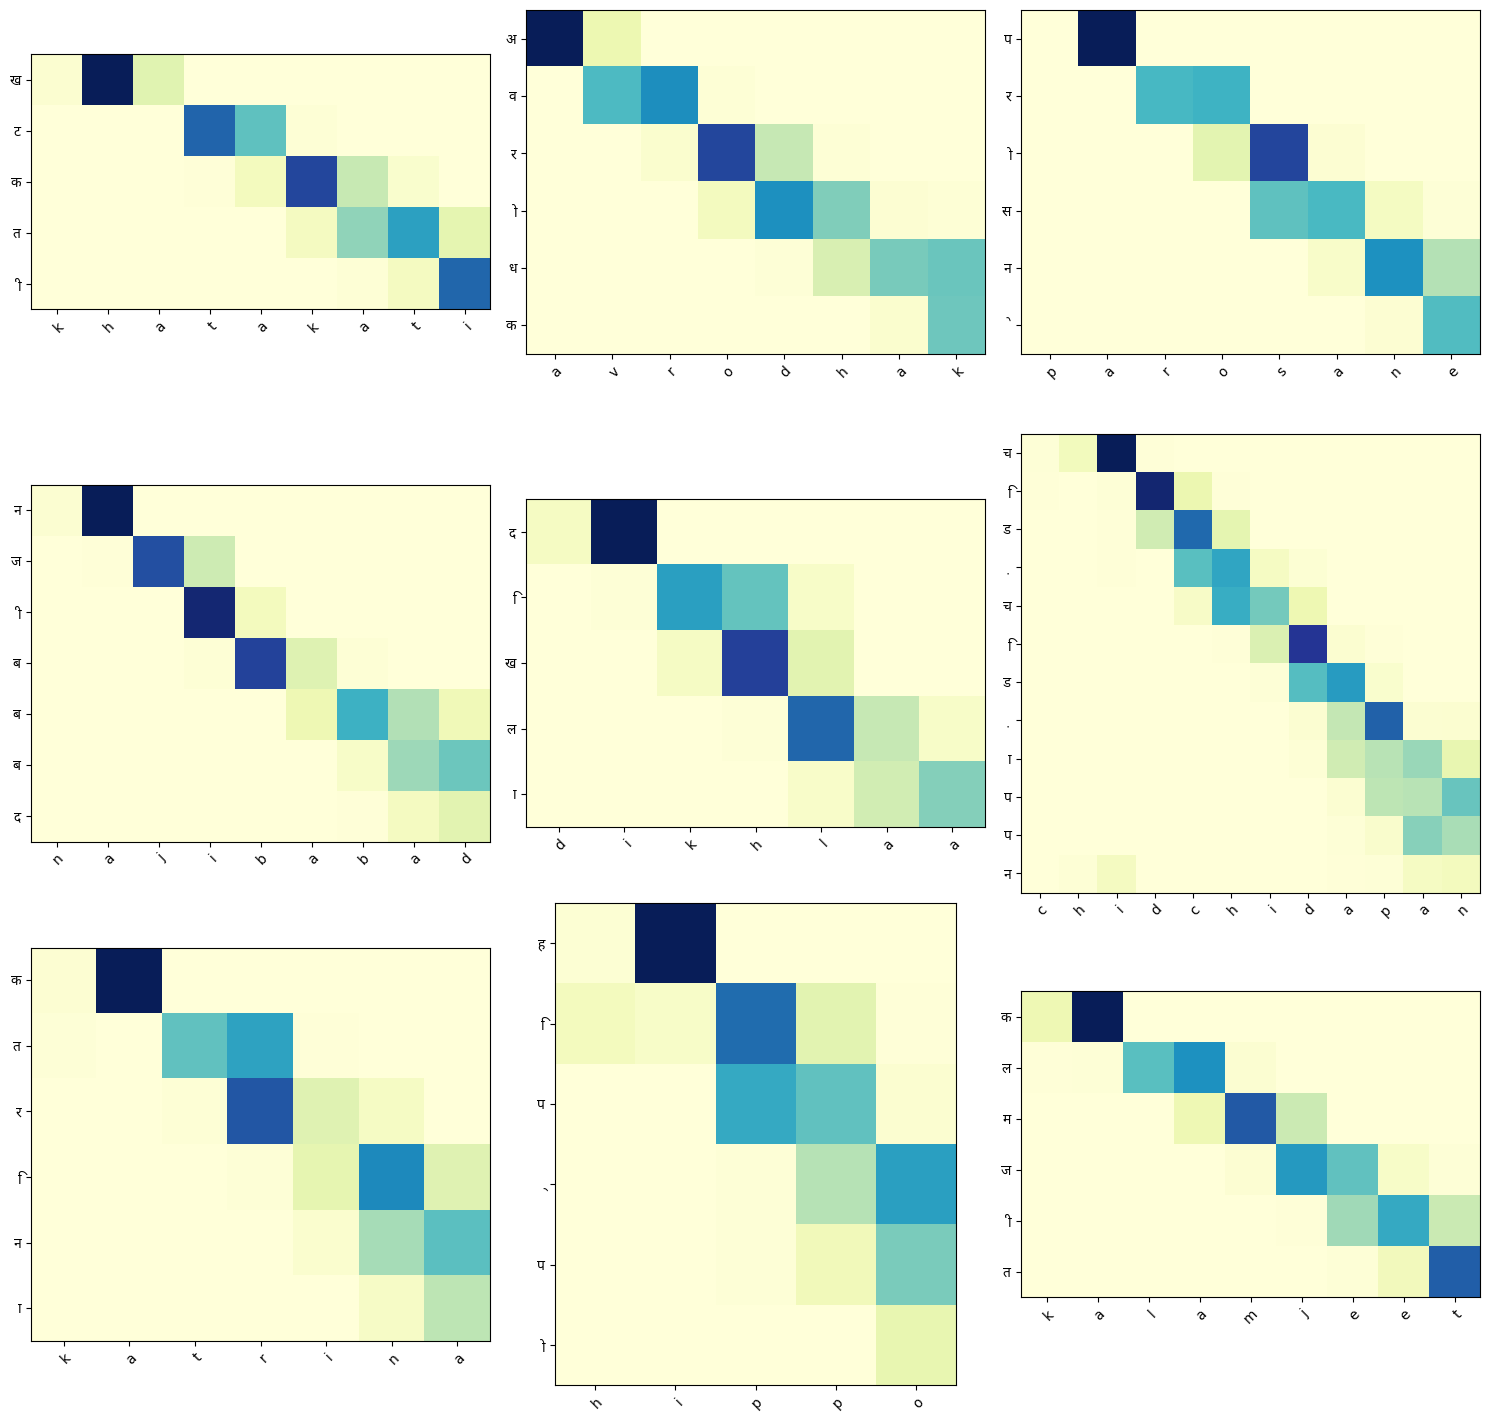

In [14]:
# Generate attention heatmaps
attention_examples = generate_attention_heatmaps('/kaggle/working/best_attention_model.pt', num_examples=9)

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import random

# Function to get color based on activation value
def get_color(value):
    """
    Returns a color between blue and red based on value (0-1)
    Blue (0) -> White (0.5) -> Red (1)
    """
    if value < 0.5:
        # Blue (0) to White (0.5)
        r = value * 2
        g = value * 2
        b = 1
    else:
        # White (0.5) to Red (1)
        r = 1
        g = 2 - value * 2
        b = 2 - value * 2
    
    return (r, g, b)

# Function to create heatmap visualization for a specific neuron
def visualize_neuron_activations(model_path, neuron_idx, num_examples=15):
    """
    Visualize activations of a specific neuron for multiple examples
    """
    # First, download a Devanagari font
    import os
    font_path = '/kaggle/working/NotoSansDevanagari-Regular.ttf'
    
    if not os.path.exists(font_path):
        import urllib.request
        # Create directory if not exists
        os.makedirs('/kaggle/working', exist_ok=True)
        # Download Noto Sans Devanagari font
        urllib.request.urlretrieve(
            'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf',
            font_path
        )
    
    # Register the font with matplotlib
    from matplotlib import font_manager
    font_manager.fontManager.addfont(font_path)
    font_prop = font_manager.FontProperties(fname=font_path)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load train dataset to get vocabulary
    train_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', build_vocab=True)
    source_vocab, target_vocab = train_dataset.get_vocab()
    
    # Load test dataset
    test_dataset = TransliterationDataset('/kaggle/input/dakshina-hi-lexicons/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', 
                                         source_vocab, target_vocab)
    
    # Create model with same architecture as training
    encoder = Encoder(
        input_size=len(source_vocab[0]),
        embedding_size=128,
        hidden_size=512,
        num_layers=3,
        dropout=0.3,
        cell_type='gru'
    )
    
    # Create a modified decoder that saves hidden states
    class DecoderWithStateCapture(AttentionDecoder):
        def __init__(self, *args, **kwargs):
            super(DecoderWithStateCapture, self).__init__(*args, **kwargs)
            self.saved_states = []
            
        def forward(self, x, hidden, encoder_outputs):
            # Original implementation
            embedded = self.dropout(self.embedding(x))
            attn_weights = self.attention(hidden, encoder_outputs)
            
            # Save attention weights for visualization
            attn_weights = attn_weights.unsqueeze(1)
            context = torch.bmm(attn_weights, encoder_outputs)
            rnn_input = torch.cat((embedded, context), dim=2)
            
            if self.cell_type == 'lstm':
                output, (hidden, cell) = self.rnn(rnn_input, hidden)
                # Save hidden state for visualization
                self.saved_states.append(hidden[-1].detach().cpu())
                
                output = torch.cat((output, context), dim=2)
                prediction = self.softmax(self.fc_out(output))
                return prediction, (hidden, cell)
            else:  # GRU or RNN
                output, hidden = self.rnn(rnn_input, hidden)
                # Save hidden state for visualization
                self.saved_states.append(hidden[-1].detach().cpu())
                
                output = torch.cat((output, context), dim=2)
                prediction = self.softmax(self.fc_out(output))
                return prediction, hidden
    
    # Create the decoder with state capture
    decoder = DecoderWithStateCapture(
        output_size=len(target_vocab[0]),
        embedding_size=128,
        hidden_size=512,
        num_layers=3,
        dropout=0.3,
        cell_type='gru'
    )
    
    # Create the seq2seq model
    model = AttentionSeq2Seq(encoder, decoder, device).to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Create directory for visualizations
    os.makedirs('neuron_visualizations', exist_ok=True)
    
    # Select random examples from test set
    random.seed(42)  # For reproducibility
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    # Generate predictions and collect activations
    examples = []
    
    with torch.no_grad():
        for idx in example_indices:
            item = test_dataset[idx]
            source = item['source'].unsqueeze(0).to(device)  # Add batch dimension
            source_text = item['source_text']
            target_text = item['target_text']
            
            # Clear saved states
            model.decoder.saved_states = []
            
            # Generate prediction
            encoder_outputs, encoder_hidden = model.encoder(source)
            decoder_hidden = model.adjust_hidden_state(encoder_hidden)
            
            # Start with <SOW> token
            decoder_input = torch.tensor([[test_dataset.SOW_idx]]).to(device)
            
            # Store predicted indices
            predicted_indices = []
            
            # Generate characters one by one
            for _ in range(50):  # Maximum length
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden, encoder_outputs)
                
                # Get the highest probability character
                top1 = decoder_output.argmax(2)
                predicted_indices.append(top1.item())
                
                # If end token is predicted, stop
                if top1.item() == test_dataset.EOW_idx:
                    break
                
                # Use predicted token as next input
                decoder_input = top1
            
            # Convert indices to characters
            pred_word = []
            for idx in predicted_indices:
                if idx == test_dataset.EOW_idx:
                    break
                if idx > 3:  # Skip special tokens
                    pred_word.append(target_vocab[1][idx])
            
            pred_word = ''.join(pred_word)
            
            # Get hidden states
            hidden_states = torch.stack(model.decoder.saved_states)
            
            # Apply sigmoid to get activation probabilities
            activations = torch.sigmoid(hidden_states).numpy()
            
            # Extract activations for the specific neuron
            neuron_activations = activations[:, 0, neuron_idx]
            
            # Store example data
            examples.append({
                'source': source_text,
                'target': target_text,
                'prediction': pred_word,
                'correct': pred_word == target_text,
                'activations': neuron_activations
            })
    
    # Create visualization
    fig = plt.figure(figsize=(12, len(examples) * 0.5))
    
    # Create a custom colormap from blue to white to red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
    cmap = LinearSegmentedColormap.from_list('bwr', colors, N=100)
    
    # Prepare the visualization data
    all_chars = []
    all_activations = []
    
    for i, example in enumerate(examples):
        chars = list(example['prediction'])
        activations = example['activations'][:len(chars)]
        
        all_chars.extend(chars)
        all_activations.extend(activations)
    
    # Reshape data for visualization
    max_len = max(len(ex['prediction']) for ex in examples)
    char_grid = np.full((len(examples), max_len), '', dtype=object)
    activation_grid = np.zeros((len(examples), max_len))
    
    for i, example in enumerate(examples):
        chars = list(example['prediction'])
        activations = example['activations'][:len(chars)]
        
        for j, (char, act) in enumerate(zip(chars, activations)):
            char_grid[i, j] = char
            activation_grid[i, j] = act
    
    # Create figure for visualization
    plt.figure(figsize=(max_len * 0.6, len(examples) * 0.5))
    
    # Plot each character with its activation color
    for i in range(len(examples)):
        for j in range(len(examples[i]['prediction'])):
            char = char_grid[i, j]
            if char == '':
                continue
                
            activation = activation_grid[i, j]
            color = get_color(activation)
            
            plt.text(j, -i, char, 
                     color='black',
                     backgroundcolor=color,
                     fontsize=12,
                     ha='center',
                     va='center',
                     fontproperties=font_prop)
    
    plt.xlim(-0.5, max_len)
    plt.ylim(-len(examples), 0.5)
    plt.axis('off')
    plt.title(f'Activations of Neuron {neuron_idx}')
    plt.tight_layout()
    plt.savefig(f'neuron_visualizations/neuron_{neuron_idx}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return examples

# Function to create visualizations for multiple neurons
def visualize_multiple_neurons(model_path, neuron_indices, num_examples=15):
    """
    Visualize activations for multiple neurons
    """
    for neuron_idx in neuron_indices:
        print(f"Visualizing neuron {neuron_idx}...")
        visualize_neuron_activations(model_path, neuron_idx, num_examples)
    
    # Create a combined figure with all neuron visualizations
    plt.figure(figsize=(15, 5 * len(neuron_indices)))
    
    for i, neuron_idx in enumerate(neuron_indices):
        plt.subplot(len(neuron_indices), 1, i+1)
        img = plt.imread(f'neuron_visualizations/neuron_{neuron_idx}.png')
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Activations of Neuron {neuron_idx}')
    
    plt.tight_layout()
    plt.savefig('neuron_visualizations/combined.png', dpi=300, bbox_inches='tight')
    plt.show()

Visualizing neuron 25...


/tmp/ipykernel_35/3604303770.py:251: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3604303770.py:251: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3604303770.py:252: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig(f'neuron_visualizations/neuron_{neuron_idx}.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/3604303770.py:252: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig(f'neuron_visualizations/neuron_{neuron_idx}.png', dpi=300, bbox_inches='tight')


Visualizing neuron 78...
Visualizing neuron 275...
Visualizing neuron 500...


<Figure size 1200x750 with 0 Axes>

<Figure size 1200x750 with 0 Axes>

<Figure size 1200x750 with 0 Axes>

<Figure size 1200x750 with 0 Axes>

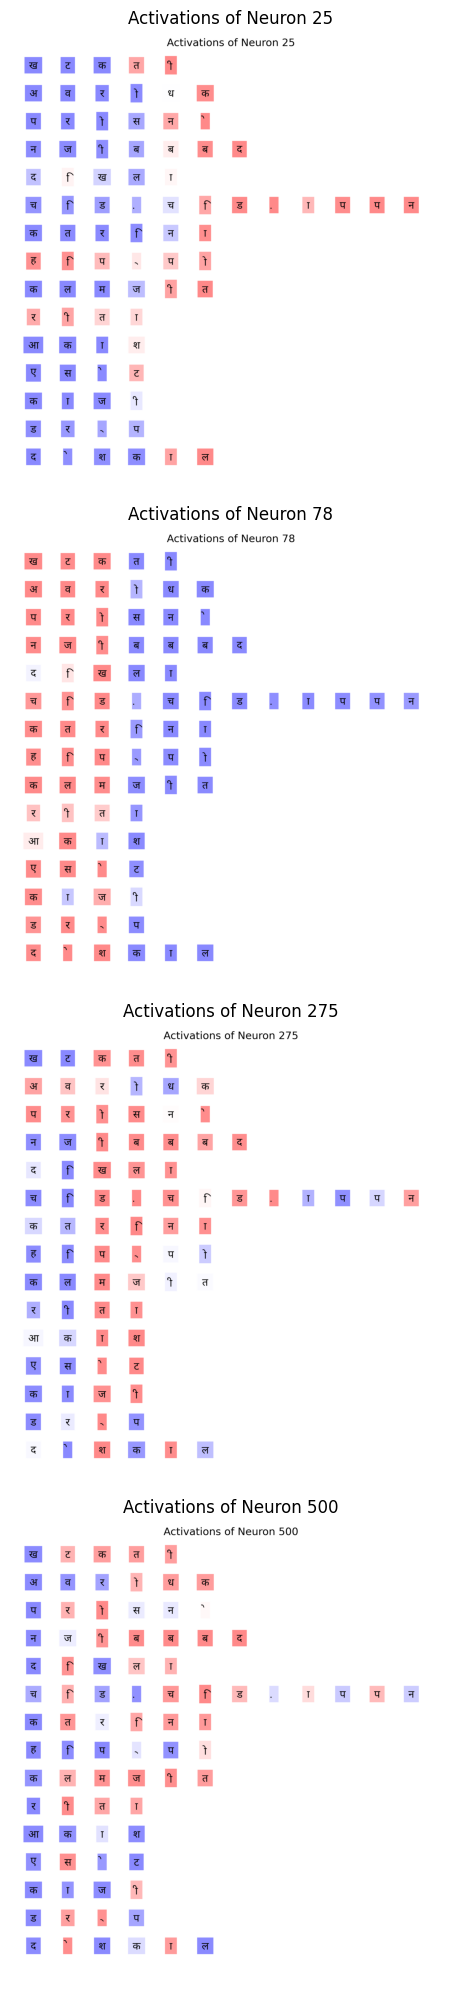

In [21]:
# Visualize neurons that might have interesting patterns
neuron_indices = [25, 78, 275, 500]  
visualize_multiple_neurons('/kaggle/working/best_attention_model.pt', neuron_indices)